In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchtext.legacy.data import Field, Dataset, Example,BucketIterator,Iterator
from torchtext.vocab import Vectors

from sklearn.metrics import f1_score,precision_score,recall_score

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

import unicodedata
import re
import codecs
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchcrf import CRF

from tqdm import tqdm

import time

from torchtext.legacy.datasets import SequenceTaggingDataset
# from BiLSTM_CRF import BiLSTM_CRF

In [2]:

DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED=2022
torch.manual_seed(SEED)

In [3]:
# label 如下所示
# label_dict={
#     'O':0,
#     'B-ORG':1,
#     'I-ORG':2,
#     'B-MISC':3,
#     'I-MISC':4,
#     'B-PER':5,
#     'I-PER':6,
#     'B-LOC':7,
#     'I-LOC':8,
# }

def zero_digits(s):
    """
    Replace every digit in a string by a zero.
    """
    return re.sub('\d', '0', s)

def load_sentences(path, lower, zeros):
    """
    Load sentences. A line must contain at least a word and its tag.
    Sentences are separated by empty lines.
    """
    text=[]
    label=[]
    text_list=[]
    label_list=[]
    for line in codecs.open(path, 'r', 'utf-8'):
        line = zero_digits(line.rstrip()) if zeros else line.rstrip()
        if not line:
            text_list.append(text)
            label_list.append(label)
            label=[]
            text=[]
        else:
            sample=line.split()
            word=sample[0]
            nertag=sample[-1]
            text.append(word)
            label.append(nertag)
    df_data=pd.DataFrame()
    df_data['text']=text_list
    df_data['label']=label_list

    return df_data

def laod_dataset(df,textfield,labelfield):

    examples=[]
    fields = [('text', textfield), ('label', labelfield)]
    for index,row in df.iterrows():
        examples.append(Example.fromlist([row['text'], row['label']], fields))
    
    dataset = Dataset(examples, fields)

    return dataset

root_path='../data/'
train_path=root_path+'eng.train'
valid_path=root_path+'eng.testa'
test_path=root_path+'eng.testb'

train_df=load_sentences(train_path,lower=True,zeros=True)
valid_df=load_sentences(valid_path,lower=True,zeros=True)
test_df=load_sentences(test_path,lower=True,zeros=True)

# inlcude_length:return (length,text),use for the mask of CRF and LSTM
TEXT=Field(sequential=True,use_vocab=True,include_lengths=True)
LABEL = Field(sequential=True,use_vocab=True,include_lengths=True)



train_data=laod_dataset(train_df,textfield=TEXT,labelfield=LABEL)
valid_data=laod_dataset(valid_df,textfield=TEXT,labelfield=LABEL)
test_data=laod_dataset(test_df,textfield=TEXT,labelfield=LABEL)

EMBEDDING_DIM=100
BATCH_SIZE=128
MIN_FREQ=2

TEXT.build_vocab(
    train_data,
    min_freq=MIN_FREQ,
    vectors="glove.6B.{}d".format(EMBEDDING_DIM),
    unk_init=torch.Tensor.normal_
)
LABEL.build_vocab(train_data)

train_iterator=BucketIterator(
    train_data,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    sort_key=lambda x: len(x.TEXT)
)

test_iterator=BucketIterator(
    test_data,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    sort_key=lambda x: len(x.TEXT)
)

valid_iterator=BucketIterator(
    valid_data,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    sort_key=lambda x: len(x.TEXT)
)





In [4]:
class BiLSTM_CRF(nn.Module):
    #定义模型中使用的所有层
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=120, num_tags=10):
        #构造函数
        super().__init__()
        #embeddding层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #lstm层
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim,
                           num_layers=1,
                           bidirectional=True, 

                           batch_first=True)
        self.crf=CRF(num_tags,batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, num_tags)

    def _get_lstm_features(self, text,text_lengths):
        embedded=self.embedding(text) #添加了padding的embedding结果

        packed_embedded=pack_padded_sequence(embedded,text_lengths,batch_first=True,enforce_sorted=False)
        packed_output,_=self.lstm(packed_embedded) #没有padding的输出
        output,output_lengths=pad_packed_sequence(packed_output, batch_first=True) #返回输出，和没有padding的

        output=self.fc(output)
        return output,output_lengths

    def neg_log_likelihood(self,text,tags,text_lengths,mask):
              
        out,_=self._get_lstm_features(text,text_lengths)
        loss=self.crf(out,tags,mask=mask)
        return -loss

    def forward(self, text,text_lengths):
        out,_=self._get_lstm_features(text,text_lengths)
        predict=self.crf.decode(out)
        return predict

INPUT_DIM = len(TEXT.vocab)
model = BiLSTM_CRF(INPUT_DIM).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.requires_grad = True





In [5]:

def _metrics(predict,tags,text_lengths):
    f1_list=[]
    precision_list=[]
    recall_list=[]

    for i in range(len(text_lengths)):
        y_true=tags[i,0:text_lengths[i]].cpu()
        y_pre=predict[i][0:text_lengths[i]]
        recall_list.append(recall_score(y_true,y_pre,average='macro',zero_division=0))
        precision_list.append(precision_score(y_true,y_pre,average='macro',zero_division=0))
        f1_list.append(f1_score(y_true,y_pre,average='macro',zero_division=0))
    f1=np.mean(f1_list)
    precision=np.mean(precision_list)
    recall= np.mean(recall_list)

    return f1,precision,recall



In [6]:
def train(model, iterator, optimizer):
    
    epoch_loss = 0

    model.train() 
    epoch_f1=0
    epoch_recall=0
    epoch_precision=0
    for batch in tqdm(iterator):

        optimizer.zero_grad()
        text=batch.text[0]
        text=text.permute(1,0)
        text_lengths=batch.text[1].cpu()

        tags=batch.label[0]
        tags=tags.permute(1,0)
        mask=torch.zeros(tags.shape,dtype=torch.uint8)
        for i in range(len(text_lengths)):
            try:
                pad_len=text_lengths[i]
                mask[i,0:pad_len]=1
            except:
                print(i,len(text_lengths))
        mask=mask.to(DEVICE)

        loss=model.neg_log_likelihood(text,tags,text_lengths,mask)

        predict=model(text,text_lengths)

        loss.backward()
        
        f1,precision,recall=_metrics(predict,tags,text_lengths)
        
        optimizer.step()
    
        epoch_f1+=f1
        epoch_precision+=precision
        epoch_recall+=recall     
        epoch_loss += loss.item()

    epoch_f1/=len(iterator)
    epoch_recall/=len(iterator)
    epoch_precision/=len(iterator)
    epoch_loss/=len(iterator)
        
    return epoch_loss ,epoch_f1,epoch_precision,epoch_recall

def evaluate(model, iterator):
    
    epoch_loss = 0
    epoch_f1=0
    epoch_recall=0
    epoch_precision=0

    model.eval() 
    
    with torch.no_grad():
    
        for batch in tqdm(iterator):

            optimizer.zero_grad()
            text=batch.text[0]
            text=text.permute(1,0)
            text_lengths=batch.text[1].cpu()
            tags=batch.label[0]
            tags=tags.permute(1,0)
            mask=torch.zeros(tags.shape,dtype=torch.uint8)
            for i in range(len(text_lengths)):
                try:
                    pad_len=text_lengths[i]
                    mask[i,0:pad_len]=1
                except:
                    print(i,len(text))
            mask=mask.to(DEVICE)
            loss=model.neg_log_likelihood(text,tags,text_lengths,mask)
            epoch_loss += loss.item()
            predict=model(text,text_lengths)
            
            f1,precision,recall=_metrics(predict,tags,text_lengths)
            
            optimizer.step()
        
            epoch_f1+=f1
            epoch_precision+=precision
            epoch_recall+=recall     

    epoch_f1/=len(iterator)
    epoch_recall/=len(iterator)
    epoch_precision/=len(iterator)
    epoch_loss/=len(iterator)
        
    return epoch_loss,epoch_f1,epoch_precision,epoch_recall

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [7]:
N_EPOCHS = 20

best_valid_f1 = float('inf')


train_loss_list=[]
train_f1_list=[]
train_precision_list=[]
train_recall_list=[]

valid_loss_list=[]
valid_f1_list=[]
valid_precision_list=[]
valid_recall_list=[]



for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss,train_f1,train_precision,train_recall = train(model, train_iterator, optimizer)
    valid_loss,valid_f1,valid_precision,valid_recall = evaluate(model, valid_iterator)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if best_valid_f1 < valid_f1:
        best_valid_f1 = valid_f1
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    train_f1_list.append(train_f1)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)

    valid_f1_list.append(valid_f1)
    valid_precision_list.append(valid_precision)
    valid_recall_list.append(valid_recall)



    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train F1: {train_f1*100:.2f}% | Train Precision: {train_precision*100:.2f}% | Train Recall: {train_recall*100:.2f}% |')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {valid_f1*100:.2f}% | Val Precision: {valid_precision*100:.2f}% | Val Recall: {valid_recall*100:.2f}% |')


  0%|          | 0/118 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torchcrf\__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ..\aten\src\ATen\native\TensorCompare.cpp:255.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Epoch: 01 | Epoch Time: 1m 18s
	Train Loss: 5799.635 | Train F1: 65.94% | Train Precision: 67.26% | Train Recall: 66.74% |
	 Val. Loss: 880.835 |  Val. F1: 75.93% | Val Precision: 77.29% | Val Recall: 76.64% |


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Epoch: 02 | Epoch Time: 1m 18s
	Train Loss: 754.719 | Train F1: 82.33% | Train Precision: 83.56% | Train Recall: 82.76% |
	 Val. Loss: 528.503 |  Val. F1: 80.87% | Val Precision: 81.87% | Val Recall: 81.48% |


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Epoch: 03 | Epoch Time: 1m 18s
	Train Loss: 230.303 | Train F1: 90.20% | Train Precision: 90.84% | Train Recall: 90.54% |
	 Val. Loss: 480.436 |  Val. F1: 83.92% | Val Precision: 84.80% | Val Recall: 84.45% |


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Epoch: 04 | Epoch Time: 1m 17s
	Train Loss: 147.948 | Train F1: 92.86% | Train Precision: 93.34% | Train Recall: 93.15% |
	 Val. Loss: 401.246 |  Val. F1: 85.14% | Val Precision: 85.82% | Val Recall: 85.71% |


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Epoch: 05 | Epoch Time: 1m 17s
	Train Loss: 118.900 | Train F1: 94.23% | Train Precision: 94.60% | Train Recall: 94.51% |
	 Val. Loss: 409.979 |  Val. F1: 84.86% | Val Precision: 85.48% | Val Recall: 85.63% |


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Epoch: 06 | Epoch Time: 1m 17s
	Train Loss: 101.016 | Train F1: 94.83% | Train Precision: 95.17% | Train Recall: 95.09% |
	 Val. Loss: 392.830 |  Val. F1: 85.28% | Val Precision: 85.97% | Val Recall: 85.91% |


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Epoch: 07 | Epoch Time: 1m 18s
	Train Loss: 93.250 | Train F1: 95.29% | Train Precision: 95.62% | Train Recall: 95.52% |
	 Val. Loss: 403.610 |  Val. F1: 85.66% | Val Precision: 86.34% | Val Recall: 86.27% |


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Epoch: 08 | Epoch Time: 1m 17s
	Train Loss: 85.647 | Train F1: 95.41% | Train Precision: 95.72% | Train Recall: 95.65% |
	 Val. Loss: 414.739 |  Val. F1: 85.98% | Val Precision: 86.73% | Val Recall: 86.48% |


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Epoch: 09 | Epoch Time: 1m 16s
	Train Loss: 80.422 | Train F1: 95.64% | Train Precision: 95.94% | Train Recall: 95.87% |
	 Val. Loss: 389.016 |  Val. F1: 86.16% | Val Precision: 86.92% | Val Recall: 86.62% |


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Epoch: 10 | Epoch Time: 1m 16s
	Train Loss: 78.046 | Train F1: 95.78% | Train Precision: 96.05% | Train Recall: 96.02% |
	 Val. Loss: 391.719 |  Val. F1: 86.06% | Val Precision: 86.78% | Val Recall: 86.63% |


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Epoch: 11 | Epoch Time: 1m 16s
	Train Loss: 74.868 | Train F1: 95.94% | Train Precision: 96.19% | Train Recall: 96.19% |
	 Val. Loss: 420.893 |  Val. F1: 86.05% | Val Precision: 86.77% | Val Recall: 86.49% |


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Epoch: 12 | Epoch Time: 1m 16s
	Train Loss: 72.597 | Train F1: 96.00% | Train Precision: 96.26% | Train Recall: 96.24% |
	 Val. Loss: 392.110 |  Val. F1: 86.06% | Val Precision: 86.68% | Val Recall: 86.70% |


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Epoch: 13 | Epoch Time: 1m 16s
	Train Loss: 71.026 | Train F1: 96.13% | Train Precision: 96.38% | Train Recall: 96.36% |
	 Val. Loss: 414.120 |  Val. F1: 86.11% | Val Precision: 86.92% | Val Recall: 86.53% |


100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Epoch: 14 | Epoch Time: 1m 16s
	Train Loss: 70.904 | Train F1: 96.08% | Train Precision: 96.35% | Train Recall: 96.30% |
	 Val. Loss: 391.371 |  Val. F1: 86.17% | Val Precision: 86.94% | Val Recall: 86.63% |


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Epoch: 15 | Epoch Time: 1m 16s
	Train Loss: 68.528 | Train F1: 96.16% | Train Precision: 96.39% | Train Recall: 96.40% |
	 Val. Loss: 383.517 |  Val. F1: 85.95% | Val Precision: 86.55% | Val Recall: 86.59% |


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Epoch: 16 | Epoch Time: 1m 16s
	Train Loss: 67.656 | Train F1: 96.17% | Train Precision: 96.41% | Train Recall: 96.40% |
	 Val. Loss: 391.921 |  Val. F1: 85.68% | Val Precision: 86.37% | Val Recall: 86.25% |


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Epoch: 17 | Epoch Time: 1m 16s
	Train Loss: 66.517 | Train F1: 96.33% | Train Precision: 96.57% | Train Recall: 96.54% |
	 Val. Loss: 382.063 |  Val. F1: 85.98% | Val Precision: 86.58% | Val Recall: 86.58% |


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Epoch: 18 | Epoch Time: 1m 16s
	Train Loss: 65.194 | Train F1: 96.43% | Train Precision: 96.66% | Train Recall: 96.65% |
	 Val. Loss: 388.119 |  Val. F1: 86.48% | Val Precision: 87.16% | Val Recall: 86.98% |


100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Epoch: 19 | Epoch Time: 1m 16s
	Train Loss: 69.250 | Train F1: 96.28% | Train Precision: 96.51% | Train Recall: 96.49% |
	 Val. Loss: 386.934 |  Val. F1: 86.51% | Val Precision: 87.06% | Val Recall: 87.12% |


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]

Epoch: 20 | Epoch Time: 1m 16s
	Train Loss: 65.838 | Train F1: 96.33% | Train Precision: 96.58% | Train Recall: 96.53% |
	 Val. Loss: 392.938 |  Val. F1: 86.66% | Val Precision: 87.29% | Val Recall: 87.20% |


![](../pic/BiLSTM_CRF-loss-20.jpg)


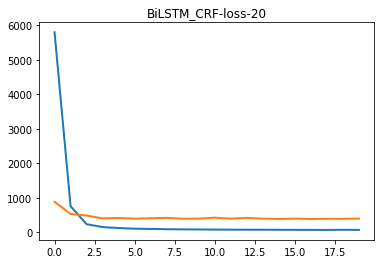

![](../pic/BiLSTM_CRF-F1-20.jpg)


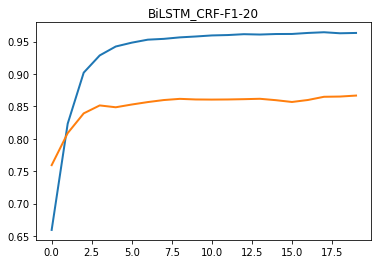

![](../pic/BiLSTM_CRF-precision-20.jpg)


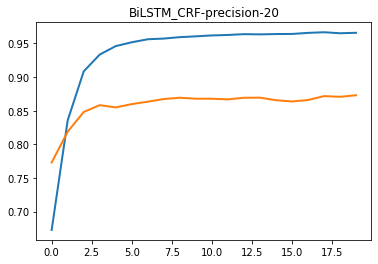

![](../pic/BiLSTM_CRF-recall-20.jpg)


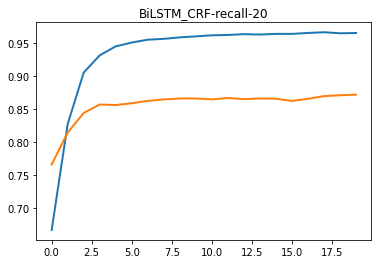

In [8]:
def drawpic(train_loss_list=[],test_loss_list=[],epoch_number=10,title='1',root_path='./'):
    # make data
    x = [i for i in range(epoch_number)]
    # plot
    fig, ax = plt.subplots()
    plt.title(title)
    ax.plot(x, train_loss_list, linewidth=2.0)
    ax.plot(x, test_loss_list, linewidth=2.0)
    path=root_path+title+'.jpg'
    print('![]({})'.format(path))
    plt.savefig(path)
    plt.show()
root_path='../pic/'
title='BiLSTM_CRF-loss-{}'.format(str(N_EPOCHS))

drawpic(train_loss_list=train_loss_list,test_loss_list=valid_loss_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

title='BiLSTM_CRF-F1-{}'.format(str(N_EPOCHS))

drawpic(train_loss_list=train_f1_list,test_loss_list=valid_f1_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

title='BiLSTM_CRF-precision-{}'.format(str(N_EPOCHS))

drawpic(train_loss_list=train_precision_list,test_loss_list=valid_precision_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

title='BiLSTM_CRF-recall-{}'.format(str(N_EPOCHS))

drawpic(train_loss_list=train_recall_list,test_loss_list=valid_recall_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

In [9]:
model.load_state_dict(torch.load('tut1-model.pt'))



FileNotFoundError: [Errno 2] No such file or directory: 'tut1-model.pt'